In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, f1_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the BERT generated risk score structured dataset
df = pd.read_csv("../data/processed_with_bert_score.csv")

# Add engineered features
df['loan_to_income'] = df['loan_amnt'] / df['annual_inc']
df['installment_ratio'] = df['installment'] / (df['annual_inc'] / 12)

print(f"Dataset after adding features: {df.shape}")


Dataset after adding features: (14971, 152)


/var/folders/1n/k2rpq0810dl2zgrrw3bk2tlw0000gn/T/ipykernel_14043/3849390135.py:2: DtypeWarning: Columns (123,124,125,128,129,130,133) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/processed_with_bert_score.csv")


In [3]:
# Define Feature Lists
numerical_features = [
    'sentiment_score',
    'readability_score',
    'income_to_loan',
    'loan_amnt',
    'installment',
    'annual_inc',
    'dti',
    'bert_risk_score',
    'revol_util',
    'open_acc',
    'pub_rec',
    'total_acc',
    'loan_to_income',
    'installment_ratio'
]

categorical_features = ['emp_length', 'home_ownership', 'purpose', 'term']
target = 'loan_status_binary'


In [4]:
# Keep only needed columns and drop rows with missing values
df = df[numerical_features + categorical_features + [target]].dropna()

# One-hot encode categorical features
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# Clean column names for XGBoost
df.columns = df.columns.str.replace('[\[\]<>()]', '_', regex=True)

# Define X and y
X = df.drop(columns=[target])
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Scale numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


<>:8: SyntaxWarning: invalid escape sequence '\['
<>:8: SyntaxWarning: invalid escape sequence '\['
/var/folders/1n/k2rpq0810dl2zgrrw3bk2tlw0000gn/T/ipykernel_14043/2639496460.py:8: SyntaxWarning: invalid escape sequence '\['
  df.columns = df.columns.str.replace('[\[\]<>()]', '_', regex=True)


# 01 Logistic Regression

In [5]:
print("Logistic Regression")

lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:, 1]

print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_lr):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression
ROC-AUC: 0.8647
Accuracy: 0.7954

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      1915
           1       0.66      0.78      0.72       949

    accuracy                           0.80      2864
   macro avg       0.77      0.79      0.78      2864
weighted avg       0.81      0.80      0.80      2864



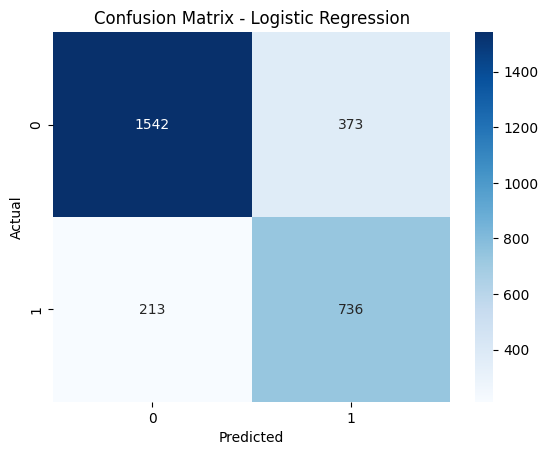

In [6]:
cm = confusion_matrix(y_test, y_pred_lr)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

In [7]:
fpr_bert, tpr_bert, _ = roc_curve(y_test, y_pred_lr)
roc_auc_base = auc(fpr_bert, tpr_bert)

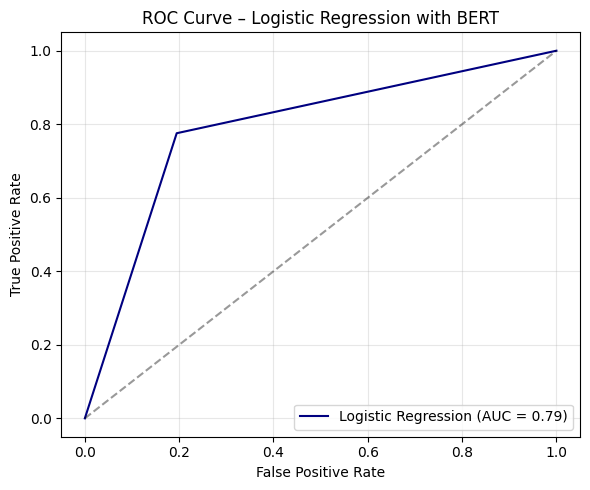

In [8]:
# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr_bert, tpr_bert, label=f"Logistic Regression (AUC = {roc_auc_base:.2f})", color='navy')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.4)
plt.title("ROC Curve – Logistic Regression with BERT")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 02 Random Forest

In [9]:
print("Random Forest")

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=4,
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_rf):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))


Random Forest
ROC-AUC: 0.8592
Accuracy: 0.7905

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      1915
           1       0.66      0.78      0.72       949

    accuracy                           0.80      2864
   macro avg       0.77      0.79      0.78      2864
weighted avg       0.81      0.80      0.80      2864



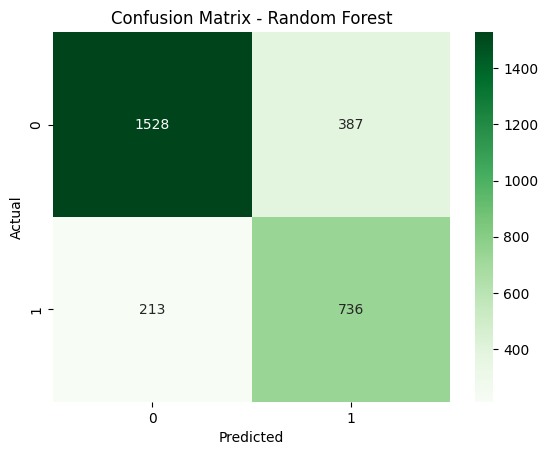

In [11]:
cm = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# 03 XGBoost

In [12]:
print("XGBoost")

xgb = XGBClassifier(
    eval_metric='logloss',
    scale_pos_weight=2.0,
    max_depth=4,
    n_estimators=300,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_xgb):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))


XGBoost
ROC-AUC: 0.8614
Accuracy: 0.7867

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.79      0.83      1915
           1       0.65      0.78      0.71       949

    accuracy                           0.79      2864
   macro avg       0.76      0.78      0.77      2864
weighted avg       0.80      0.79      0.79      2864



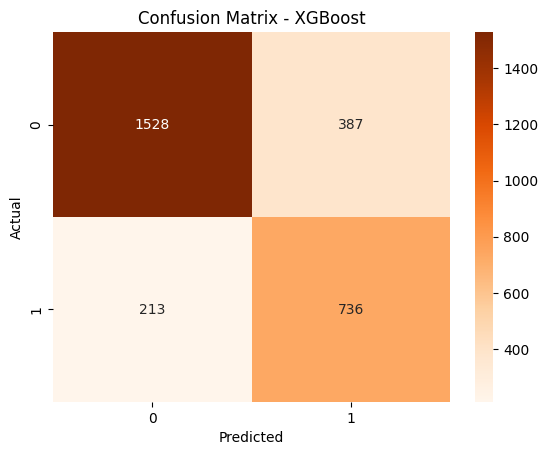

In [13]:
cm = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()

### Hyperparamter tuning for XGBoost

In [14]:
# Parameter grid
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

In [15]:
xgb = XGBClassifier(
    scale_pos_weight=2.0,  
    eval_metric='logloss',
    use_label_encoder=False
)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=20,
    scoring='f1',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [16]:
random_search.fit(X_train, y_train)
print("Best parameters:", random_search.best_params_)
print("Best F1 score during tuning:", random_search.best_score_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/anushkachougule/Desktop/inst750-final-project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:32:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anushkachougule/Desktop/inst750-final-project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:32:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anushkachougule/Desktop/inst750-final-project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:32:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/anushkachougule/Desktop/inst750-final-project/venv/lib/python3.12/site-packages/xgboost/training.py:183: 

Best parameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best F1 score during tuning: 0.7079890251998604


/Users/anushkachougule/Desktop/inst750-final-project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:32:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [18]:
best_xgb = random_search.best_estimator_
y_pred_best = best_xgb.predict(X_test)
y_prob_best = best_xgb.predict_proba(X_test)[:, 1]

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

print("Best XGBoost on test set:")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_best):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_best):.4f}")


Best XGBoost on test set:
ROC-AUC: 0.8637
Accuracy: 0.7842
F1 Score: 0.7068


In [20]:
import joblib

# Save best model
joblib.dump(best_xgb, "../models/best_xgb_model.pkl")
print("Model saved as 'best_xgb_model.pkl'")


Model saved as 'best_xgb_model.pkl'
